In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE

In [84]:
os.listdir()

['Apziva.ipynb',
 'Apziva_v2.ipynb',
 'Apziva_v3.ipynb',
 'term-deposit-marketing-2020.csv']

In [85]:
data = pd.read_csv("term-deposit-marketing-2020.csv")

Peeking at data

In [3]:
data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,no


In [4]:
#Checking percentage of missing data in each column
data.isna().sum() / len(data['age'])

age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
y            0.0
dtype: float64

We dont have any missing data. Let's now check the data types of each column.

In [5]:
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object

The binary (yes, no) variables are in type object.

I am going to convert (yes, no) to (1, 0) for these columns.

In [96]:
data.default.replace(("yes", "no"), (1,0), inplace=True)
data.housing.replace(("yes", "no"), (1, 0), inplace=True)
data.loan.replace(("yes", "no"), (1, 0), inplace=True)
data.y.replace(("yes", "no"), (1, 0), inplace=True)

# Explaratory Data Analysis

<AxesSubplot:>

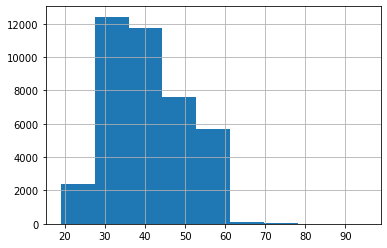

In [7]:
data.age.hist(bins=9)

Age values look skewed to left.

I will use log transformation on age column and add this as a new column 'logAge'

In [8]:
age_mean = data.age.mean()
age_std = data.age.std()
num_obs = len(data.age)
print("The mean Age is " + "{:.2f}".format(age_mean))
print("The std of Ages is " + "{:.2f}".format(age_std))
print("There are " + str(num_obs) + " observations.")

The mean Age is 40.54
The std of Ages is 9.64
There are 40000 observations.


Lets look at cdf of Age values. We will compare it with a normal distribution with same mean and std.

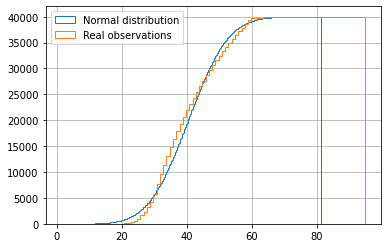

In [9]:
ages_normal = pd.Series(np.random.normal(age_mean, age_std, size= num_obs))

ages_normal.hist(cumulative=True, bins=400, histtype='step', label="Normal distribution")
data.age.hist(cumulative=True, bins=400, histtype='step', label= "Real observations")
plt.legend(loc="upper left")


plt.show()

See the age distribution after log transformation

<AxesSubplot:>

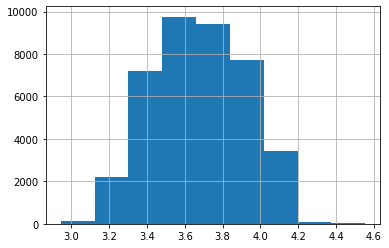

In [10]:
logAge = np.log(data.age)
logAge.hist(bins=9)

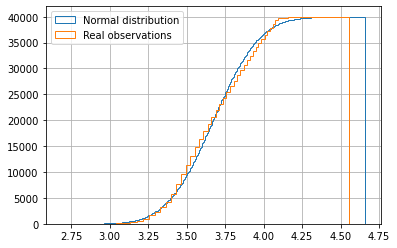

In [11]:
ages_normal = pd.Series(np.random.normal(logAge.mean(), logAge.std(), size= num_obs))

ages_normal.hist(cumulative=True, bins=400, histtype='step', label="Normal distribution")
logAge.hist(cumulative=True, bins=400, histtype='step', label= "Real observations")
plt.legend(loc="upper left")


plt.show()

Looks better after transformation.

Now lets look at what kind of and how many job categories we have.

In [12]:
data.job.value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [13]:
data.marital.value_counts()

married     24386
single      10889
divorced     4725
Name: marital, dtype: int64

In [14]:
data.education.value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [15]:
data.default.value_counts()

0    39191
1      809
Name: default, dtype: int64

In [16]:
data.balance.describe()

count     40000.000000
mean       1274.277550
std        2903.769716
min       -8019.000000
25%          54.000000
50%         407.000000
75%        1319.000000
max      102127.000000
Name: balance, dtype: float64

<AxesSubplot:>

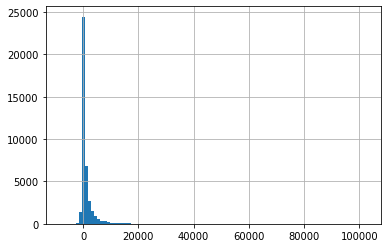

In [347]:
data.balance.hist(bins=100)

The balances are also quite unbalanced and left skewed.

I will try transforming them as well.

<AxesSubplot:>

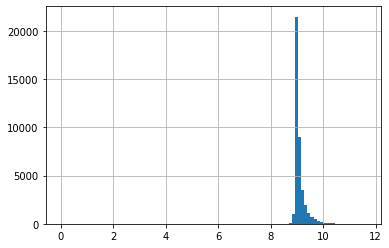

In [18]:
# Since there are zero values in balance, i am adding 1 to balance value before transforming.
# Since there are negative values, i shift the series to right
np.log(data.balance + abs(data.balance.min()) + 1).hist(bins=100)

Seems like transformation did not do much.

I will not use transformed version and continue with the original column.

In [19]:
data.housing.value_counts()

1    24031
0    15969
Name: housing, dtype: int64

In [20]:
data.contact.value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

<AxesSubplot:>

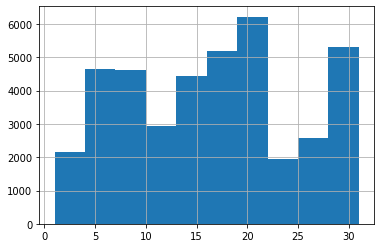

In [21]:
data.day.hist()

I am going to keep day column as it is. Just wanted to see.

In [22]:
data.month.value_counts()

may    13532
jul     6380
aug     5215
jun     4734
nov     3598
apr     2718
feb     2296
jan     1176
mar      258
oct       80
dec       13
Name: month, dtype: int64

<AxesSubplot:>

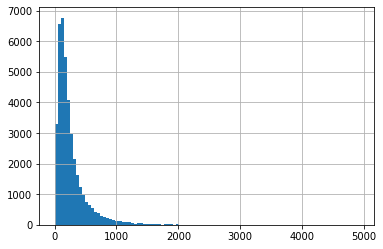

In [23]:
data.duration.hist(bins=100)

Duration values are left skewed as well. Again, I am going to try log transformation for this column.

<AxesSubplot:>

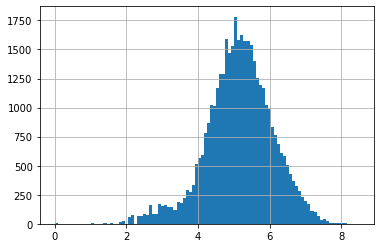

In [24]:
#Since there are 0 values in data, adding 1 to be able to perform log transformation. Assuming there will be no negative duration calls.
#(Reason is that log(0) = -inf)
np.log(data.duration + 1).hist(bins=100)

After the transformation, the skewness is gone almost completely

# Subscribe rates by features

Now i will plot the subscribing rate for the features.

This will give us some idea about the importance of features on subscription.

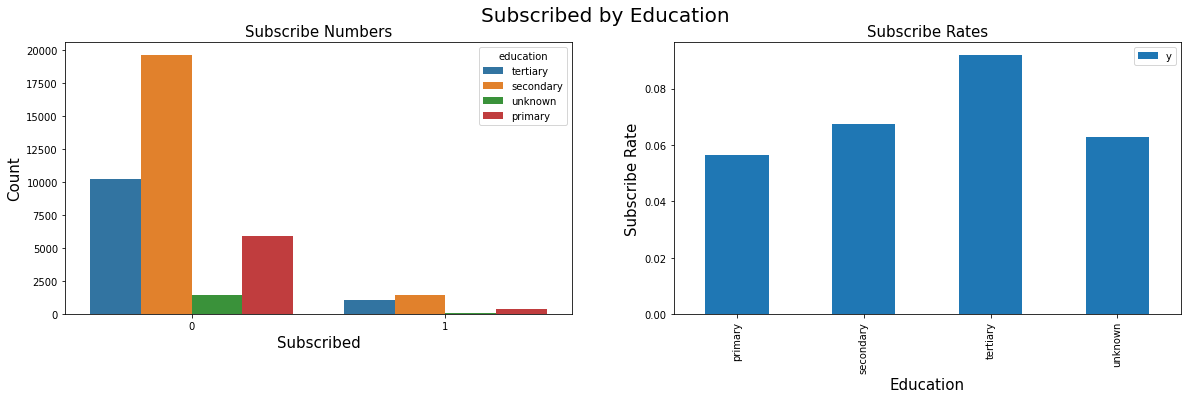

In [344]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Subscribed by Education', fontsize=20)

data1 = data[['education','y']].groupby(by='education').mean()
sns.countplot(data=data, x="y", hue="education", ax=axes[0])
data1.plot(kind='bar', ax=axes[1])
axes[0].set_title("Subscribe Numbers", fontsize=15)
axes[1].set_title("Subscribe Rates", fontsize=15)

axes[0].set_xlabel('Subscribed', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Education', fontsize=15)
axes[1].set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

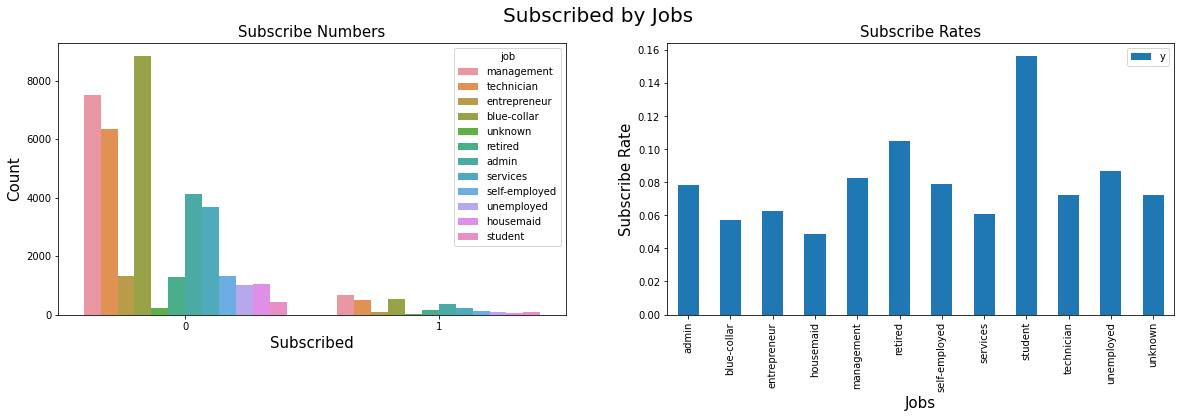

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Subscribed by Jobs', fontsize=20)

data1 = data[['job','y']].groupby(by='job').mean()
sns.countplot(data=data, x="y", hue="job", ax=axes[0])
data1.plot(kind='bar', ax=axes[1])
axes[0].set_title("Subscribe Numbers", fontsize=15)
axes[1].set_title("Subscribe Rates", fontsize=15)

axes[0].set_xlabel('Subscribed', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Jobs', fontsize=15)
axes[1].set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

Seems like student are more likely to subscribe, followed by retired.

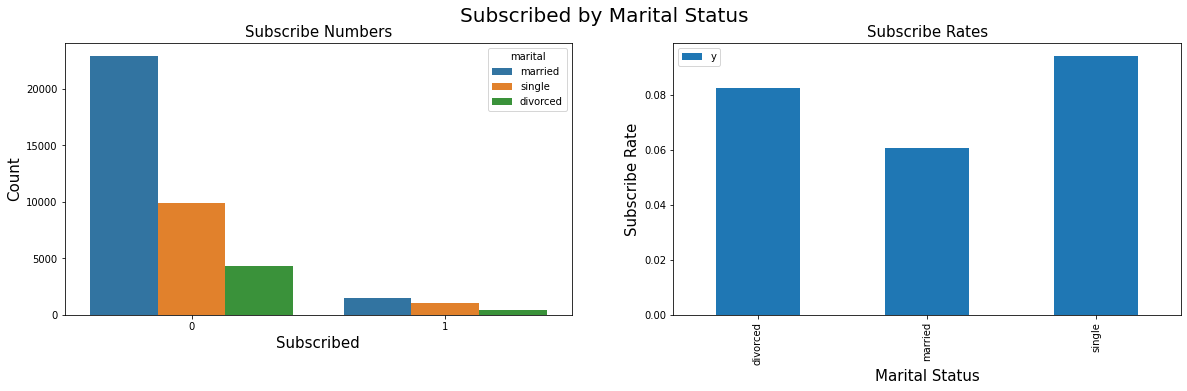

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Subscribed by Marital Status', fontsize=20)

data1 = data[['marital','y']].groupby(by='marital').mean()
sns.countplot(data=data, x="y", hue="marital", ax=axes[0])
data1.plot(kind='bar', ax=axes[1])
axes[0].set_title("Subscribe Numbers", fontsize=15)
axes[1].set_title("Subscribe Rates", fontsize=15)

axes[0].set_xlabel('Subscribed', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Marital Status', fontsize=15)
axes[1].set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

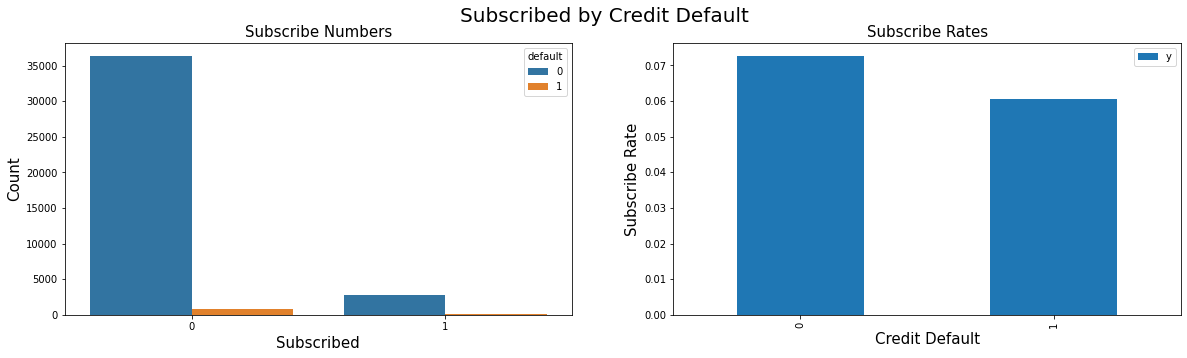

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Subscribed by Credit Default', fontsize=20)

data1 = data[['default','y']].groupby(by='default').mean()
sns.countplot(data=data, x="y", hue="default", ax=axes[0])
data1.plot(kind='bar', ax=axes[1])
axes[0].set_title("Subscribe Numbers", fontsize=15)
axes[1].set_title("Subscribe Rates", fontsize=15)

axes[0].set_xlabel('Subscribed', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Credit Default', fontsize=15)
axes[1].set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

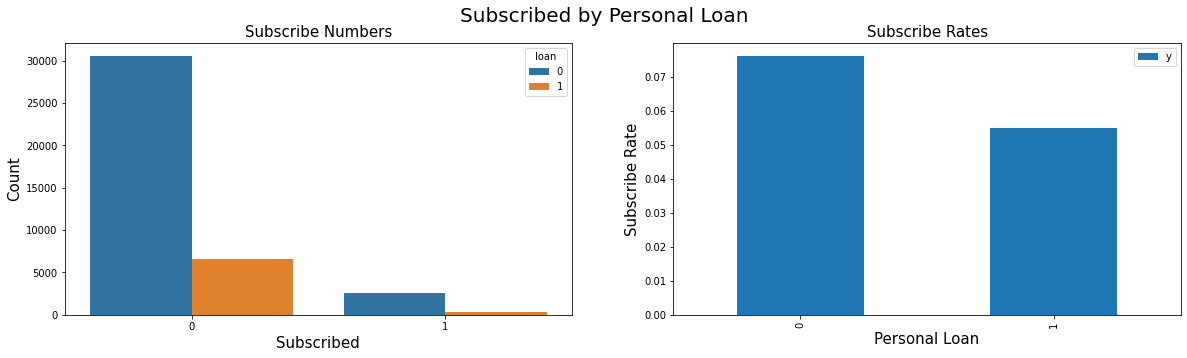

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Subscribed by Personal Loan', fontsize=20)

data1 = data[['loan','y']].groupby(by='loan').mean()
sns.countplot(data=data, x="y", hue="loan", ax=axes[0])
data1.plot(kind='bar', ax=axes[1])
axes[0].set_title("Subscribe Numbers", fontsize=15)
axes[1].set_title("Subscribe Rates", fontsize=15)

axes[0].set_xlabel('Subscribed', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Personal Loan', fontsize=15)
axes[1].set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

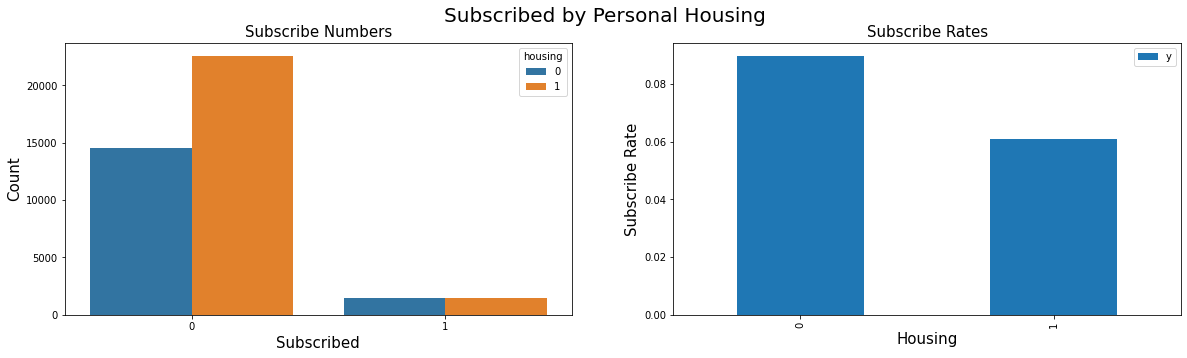

In [345]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Subscribed by Personal Housing', fontsize=20)

data1 = data[['housing','y']].groupby(by='housing').mean()
sns.countplot(data=data, x="y", hue="housing", ax=axes[0])
data1.plot(kind='bar', ax=axes[1])
axes[0].set_title("Subscribe Numbers", fontsize=15)
axes[1].set_title("Subscribe Rates", fontsize=15)

axes[0].set_xlabel('Subscribed', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Housing', fontsize=15)
axes[1].set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

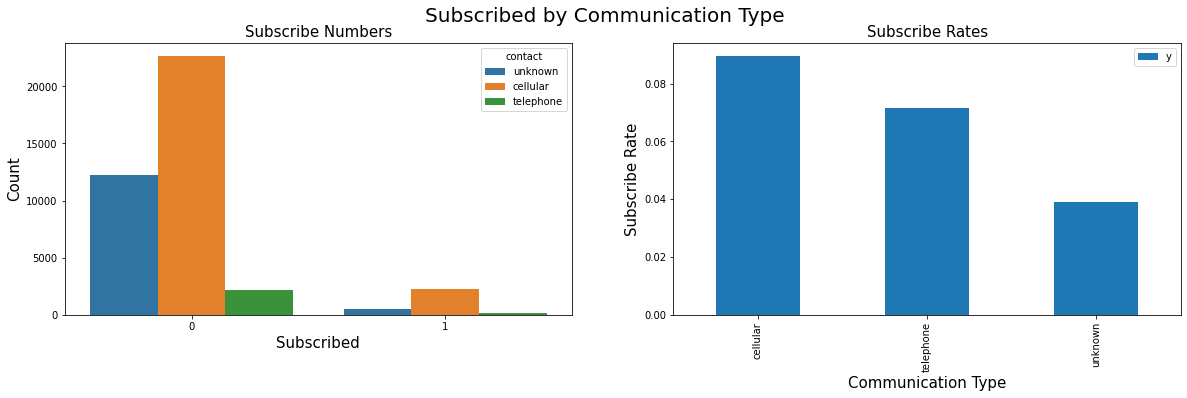

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Subscribed by Communication Type', fontsize=20)

data1 = data[['contact','y']].groupby(by='contact').mean()
sns.countplot(data=data, x="y", hue="contact", ax=axes[0])
data1.plot(kind='bar', ax=axes[1])
axes[0].set_title("Subscribe Numbers", fontsize=15)
axes[1].set_title("Subscribe Rates", fontsize=15)

axes[0].set_xlabel('Subscribed', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Communication Type', fontsize=15)
axes[1].set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

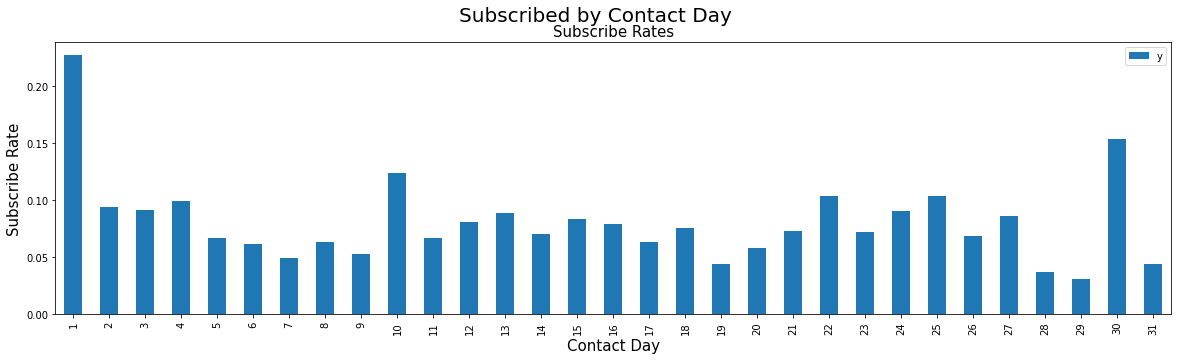

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
fig.suptitle('Subscribed by Contact Day', fontsize=20)

data1 = data[['day','y']].groupby(by='day').mean()
data1.plot(kind='bar', ax=axes)

axes.set_title("Subscribe Rates", fontsize=15)

axes.set_xlabel('Contact Day', fontsize=15)
axes.set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

From this graph it seems like the first day of the month has higher rates.

But also it feels like there is an S shaped pattern in the graph. 

Maybe it could be useful to add another column that shows the day of the week.

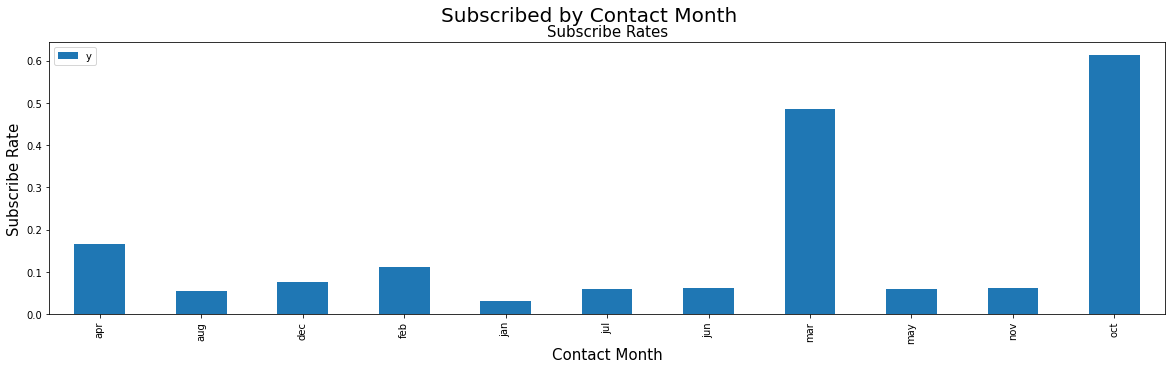

In [29]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
fig.suptitle('Subscribed by Contact Month', fontsize=20)

data1 = data[['month','y']].groupby(by='month').mean()
data1.plot(kind='bar', ax=axes)

axes.set_title("Subscribe Rates", fontsize=15)

axes.set_xlabel('Contact Month', fontsize=15)
axes.set_ylabel('Subscribe Rate', fontsize=15)
plt.show()

If the customer is contacted at October and/or March, the success rate seems higher.

# Preprocessing and Pipelines

So far we have imported and analyzed data.

We have decided to use log transformation on "age" and "duration" columns.

Now i will create a custom transformer function to log transform "age" and "duration" columns.

Then i will connect this transformer to the pipeline.

In [3]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'y'],
      dtype='object')

In [97]:
num_attr = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign']
cat_attr = ['job', 'marital', 'education', 'contact', 'month']
data_num = data[num_attr]
data_cat = data[cat_attr]
data = data_num.join(data_cat).join(data['y'])

In [98]:
age_index = 0
duration_index = 6

In [99]:
class log_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformAge = True, transformDuration = True):
        self.transformAge = transformAge
        self.transformDuration = transformDuration
    def fit(self, y=None):
        return self
    def transform(self, X, y=None):
        logAge = np.log(X.iloc[:, age_index].astype("int64"))
        logDuration = np.log(X.iloc[:, duration_index].astype("int64") + 1)
        if (self.transformAge and self.transformDuration):
            return np.c_[logAge, X.iloc[:,1:duration_index], logDuration, X.iloc[:,duration_index+1::]]
        elif self.transformAge:
            return np.c_[logAge, X.iloc[:,1::]]
        elif self.transformDuration:
            return np.c_[X.iloc[:,0:duration_index], logDuration, X.iloc[:,duration_index+1::]]
        else:
            return X

In [100]:
num_pipeline = Pipeline([
    ('log_adder', log_transformer()),
    ('std_scaler', StandardScaler())
])

In [101]:
complete_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_attr),
    ("categorical", OneHotEncoder(), cat_attr)
])

In [102]:
#Since the data is unbalanced, i will split the training and test set using StratifiedShuffleSplit balancing y column
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in split.split(data, data["y"]):
    data_train = data.loc[train_index]
    data_test = data.loc[test_index]

In [103]:
x_train = data_train.drop('y', axis=1)
y_train = data_train['y']
x_test = data_test.drop('y', axis=1)
y_test = data_test['y']

In [104]:
data_train.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'job', 'marital', 'education', 'contact', 'month', 'y'],
      dtype='object')

In [105]:
complete_pipeline.fit(x_train)
x_train_transformed = complete_pipeline.transform(x_train)
x_test_transformed = complete_pipeline.transform(x_test)

In [106]:
#Oversampling the minority class
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_sample(x_train_transformed,y_train)

In [107]:
len(x_train_smote)

59366

In [108]:
len(num_attr)

8

In [109]:
len(complete_pipeline.named_transformers_['categorical'].get_feature_names())

33

In [110]:
x_train_transformed.shape

(32000, 41)

1. HOW TO CONSTRUCT A PIPELINE WITH LABEL ENCODER
2. INCLUDE PIPELINE OPTIONS IN GRIDSEARCHCV

# Model Training

## Please Read
A model's having a really good accuracy does not mean that the model is performing well because the y labels are highly unbalanced.

I will explain what Precision and Recall mean considering our problem:

    We are trying to sell a product to our customers.

    In this case, the Precision is -> The percentage of customers that actually bought the product out of the customers that we thought would buy.

    The Recall is -> The percentage of customers that we tought would buy the product out of the customers which would actually buy.

    Low precision means that we aim wrong customers.(we focus on customers which dont want to buy)

    Low recall means that we miss the customers that actually want to buy.(In reality the customer will buy but we think that (s)he won't buy)

For this particular problem, i find achieving high recall more meaningful. This means that we will put our focus on not missing the customers that want to buy the product but as a tradeoff we will increase our call rates that ends up with no sales.

Deciding between precision and recall tradeoff is actually a strategic decision. But since this is a case study, i will be the one deciding the optimal point.

I will try to find a balance between these scores without sacrificing to much accuracy. 

Now i will try different models with different parameters using GridSearchCV and i will choose the model with highest 'roc_auc' score which gives the area under a roc curve. (The model with higher 'roc_auc' score promises a better tradeoff opportunities and better scores in general)

In [114]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [115]:
from sklearn.metrics.scorer import make_scorer
def my_custom_loss_func(y_true, y_pred):
    true_positives = ((y_true == 1) & (y_pred == 1)).sum()
    false_negatives = ((y_true == 1) & (y_pred == 0)).sum()
    recalls = true_positives / (true_positives + false_negatives)   
    accuracy =  (y_true == y_pred).sum() / len(y_pred)

    result = recalls

    return result

scorer = make_scorer(my_custom_loss_func, greater_is_better=True)

## 1. Logistic Regression

In [111]:
from sklearn.linear_model import LogisticRegression

lr_params = {
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C' : [5, 10, 20]
}

lr = LogisticRegression(verbose = 3)
lr_model = GridSearchCV(lr, lr_params, scoring="roc_auc", cv = 5, n_jobs=-3, verbose=3)
lr_model.fit(x_train_smote, y_train_smote)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-3)]: Done  12 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-3)]: Done  75 out of  75 | elapsed:   25.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


GridSearchCV(cv=5, estimator=LogisticRegression(verbose=3), n_jobs=-3,
             param_grid={'C': [5, 10, 20],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc', verbose=3)

In [132]:
lr_predictions = lr_model.predict(x_train_smote)
lr_probas = lr_model.predict_proba(x_train_smote)
print("Logistic Regression Best Score : " + "{:.2f}%".format(lr_model.best_score_*100))
print("Logistic Regression Accuracy: " + "{:.2f}%".format(100*np.array(lr_predictions == y_train_smote).sum() / len(x_train_smote)))
print("Logistic Regression Precision Score: " + "{:.2f}%".format(100*precision_score(y_train_smote, lr_predictions)))
print("Logistic Regression Recall Score: " + "{:.2f}%".format(100*recall_score(y_train_smote, lr_predictions)))

Logistic Regression Best Score : 93.49%
Logistic Regression Accuracy: 87.51%
Logistic Regression Precision Score: 85.54%
Logistic Regression Recall Score: 90.28%


Actually, for now all i want to see from here is the Best Score which is 'roc_auc' score

The Accuracy, Precision and Recall values here are given with default threshold value. (We did not work through the tradeoffs yet.)

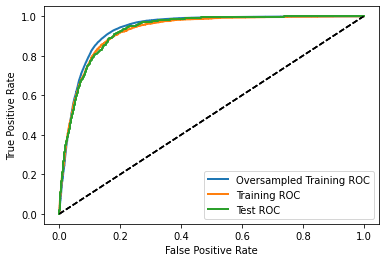

In [138]:
fpr_lr_smote, tpr_lr_smote, thresholds_lr_smote = roc_curve(y_train_smote, lr_probas[:,1])
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train, lr_model.predict_proba(x_train_transformed)[:,1])
fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test, lr_model.predict_proba(x_test_transformed)[:,1])
plot_roc_curve(fpr_lr_smote, tpr_lr_smote, label="Oversampled Training ROC")
plot_roc_curve(fpr_lr, tpr_lr, label="Training ROC")
plot_roc_curve(fpr_lr_test, tpr_lr_test, label="Test ROC")
plt.legend(loc="lower right")
plt.show()

In [118]:
confusion_matrix(y_train_smote, lr_predictions)

array([[25154,  4529],
       [ 2885, 26798]], dtype=int64)

In [119]:
confusion_matrix(y_test, lr_model.predict(x_test_transformed))

array([[6244, 1177],
       [  76,  503]], dtype=int64)

# 2. Random Forest

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(n_estimators=1000, max_depth=8, verbose = 0)
rf_model.fit(x_train_smote, y_train_smote)
cross_val_score(rf_model, X=x_train_smote, y=y_train_smote, scoring="roc_auc", cv = 5, n_jobs=-3, verbose=0)

array([0.93880935, 0.94942221, 0.94949742, 0.95208606, 0.95105636])

Initially, i have added more combinations to rf_params but random forest model is overfitting.

To prevent overfitting, i am using high n_estimators and low max_depth

In [161]:
rf_predictions = rf_model.predict(x_train_smote)
rf_probas = rf_model.predict_proba(x_train_smote)
print("Random Forest ROC_AUC : " + "{:.2f}%".format(roc_auc_score(y_train_smote, rf_probas[:,1])*100))
print("Random Forest Accuracy: " + "{:.2f}%".format(100*np.array(rf_predictions == y_train_smote).sum() / len(x_train_smote)))
print("Random Forest Precision Score: " + "{:.2f}%".format(100*precision_score(y_train_smote, rf_predictions)))
print("Random Forest Recall Score: " + "{:.2f}%".format(100*recall_score(y_train_smote, rf_predictions)))

Random Forest ROC_AUC : 97.77%
Random Forest Accuracy: 92.28%
Random Forest Precision Score: 90.13%
Random Forest Recall Score: 94.95%


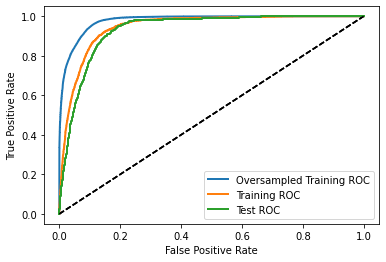

In [162]:
fpr_rf_smote, tpr_rf_smote, thresholds_rf_smote = roc_curve(y_train_smote, rf_probas[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, rf_model.predict_proba(x_train_transformed)[:,1])
fpr_rf_test, tpr_rf_test, thresholds_rf_test = roc_curve(y_test, rf_model.predict_proba(x_test_transformed)[:,1])
plot_roc_curve(fpr_rf_smote, tpr_rf_smote, label="Oversampled Training ROC")
plot_roc_curve(fpr_rf, tpr_rf, label="Training ROC")
plot_roc_curve(fpr_rf_test, tpr_rf_test, label="Test ROC")
plt.legend(loc="lower right")
plt.show()

In [163]:
confusion_matrix(y_train_smote, rf_predictions)

array([[26598,  3085],
       [ 1498, 28185]], dtype=int64)

In [164]:
confusion_matrix(y_test, rf_model.predict(x_test_transformed))

array([[6585,  836],
       [ 108,  471]], dtype=int64)

# 3. XGBoost

In [204]:
import xgboost

xgb_model = xgboost.XGBClassifier(objective='binary:logistic',min_child_weight=10, subsample=0.35, colsample_bytree=0.35, max_depth=3, learning_rate=0.01, n_estimators=1000,silent=True, nthread=-3)
xgb_model.fit(x_train_smote, y_train_smote)
cross_val_score(xgb_model, X=x_train_smote, y=y_train_smote, scoring="roc_auc", cv = 5, n_jobs=-3, verbose=0)

[16:17:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:17:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.96858344, 0.98491524, 0.98357051, 0.98562132, 0.98443848])

In [205]:
xgb_predictions = xgb_model.predict(x_train_smote)
xgb_probas = xgb_model.predict_proba(x_train_smote)
print("XGBoost ROC_AUC : " + "{:.2f}%".format(roc_auc_score(y_train_smote, xgb_probas[:,1])*100))
print("XGBoost Accuracy: " + "{:.2f}%".format(100*np.array(xgb_predictions == y_train_smote).sum() / len(x_train_smote)))
print("XGBoost Precision Score: " + "{:.2f}%".format(100*precision_score(y_train_smote, xgb_predictions)))
print("XGBoost Forest Recall Score: " + "{:.2f}%".format(100*recall_score(y_train_smote, xgb_predictions)))

XGBoost ROC_AUC : 98.30%
XGBoost Accuracy: 93.15%
XGBoost Precision Score: 92.00%
XGBoost Forest Recall Score: 94.53%


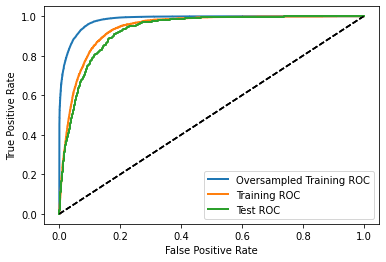

In [209]:
fpr_xgb_smote, tpr_xgb_smote, thresholds_xgb_smote = roc_curve(y_train_smote, xgb_probas[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_train, xgb_model.predict_proba(x_train_transformed)[:,1])
fpr_xgb_test, tpr_xgb_test, thresholds_xgb_test = roc_curve(y_test, xgb_model.predict_proba(x_test_transformed)[:,1])
plot_roc_curve(fpr_xgb_smote, tpr_xgb_smote, label="Oversampled Training ROC")
plot_roc_curve(fpr_xgb, tpr_xgb, label = "Training ROC")
plot_roc_curve(fpr_lr_test, tpr_lr_test, label= "Test ROC")
plt.legend(loc="lower right")
plt.show()

In [210]:
confusion_matrix(y_train, xgb_model.predict(x_train_transformed))

array([[27242,  2441],
       [  540,  1777]], dtype=int64)

In [211]:
confusion_matrix(y_test, xgb_model.predict(x_test_transformed))

array([[6780,  641],
       [ 140,  439]], dtype=int64)

# Deciding Final Model

Now i am going to plot the ROC curves for training set of all three models together and choose from them.

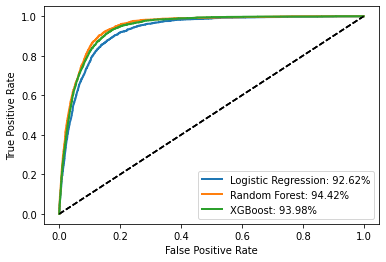

In [212]:
plot_roc_curve(fpr_lr, tpr_lr, label = "Logistic Regression: {:.2f}%".format(roc_auc_score(y_train, lr_model.predict_proba(x_train_transformed)[:,1])*100))
plot_roc_curve(fpr_rf, tpr_rf, label = "Random Forest: {:.2f}%".format(roc_auc_score(y_train, rf_model.predict_proba(x_train_transformed)[:,1])*100))
plot_roc_curve(fpr_xgb, tpr_xgb, label = "XGBoost: {:.2f}%".format(roc_auc_score(y_train, xgb_model.predict_proba(x_train_transformed)[:,1])*100))
plt.legend(loc="lower right")
plt.show()

When we look at the ROC_AUC scores, Random Forest model and XGBoost models seems a little better than Logistic Regression.

Between Random Forest and XGB, Random Forest looks better.

But since they are really close, i am going to magnify my area of interest(Recall more than 0.9) and see.

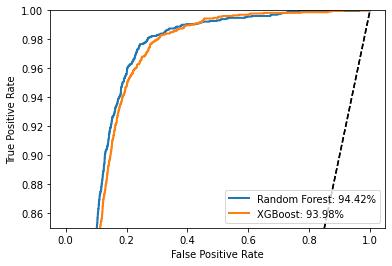

In [228]:
plot_roc_curve(fpr_rf, tpr_rf, label = "Random Forest: {:.2f}%".format(roc_auc_score(y_train, rf_model.predict_proba(x_train_transformed)[:,1])*100))
plot_roc_curve(fpr_xgb, tpr_xgb, label = "XGBoost: {:.2f}%".format(roc_auc_score(y_train, xgb_model.predict_proba(x_train_transformed)[:,1])*100))
plt.ylim(0.85, 1)
plt.legend(loc="lower right")
plt.show()

Considering training set, Random forest model seems just a little better also when Recall is around 90%

I will choose Random Forest model and play with the thresholds a little to achive desired Recall value.

After 90%-95% recall, the increasing rate of False Positive Rate is gaining speed.

I am going to try to achieve %95 recall rate on training set because it will be lower in test set.

Now i will create a data frame that shows different combinations of Recall, Precision and Accuracy of chosen model.

In [230]:
num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()
probas = rf_model.predict_proba(x_train_transformed)[:,1]
negative_predicted = [(probas >= th).sum() for th in thresholds_rf]
positive_predicted = [(probas < th).sum() for th in thresholds_rf]

In [250]:
# Converting TPR, FPR and Threshold values for easier observations
rf_combinations = pd.DataFrame(columns=["FPR","TPR","Threshold"])
rf_combinations["FPR"] = fpr_rf
rf_combinations["TPR"] = tpr_rf
rf_combinations["Threshold"] = thresholds_rf
rf_combinations["TruePositives"] = np.multiply(rf_combinations["TPR"], num_positives)
rf_combinations["FalsePositives"] = np.multiply(rf_combinations["FPR"], num_negatives)
rf_combinations["Precision"] = rf_combinations["TruePositives"] / (rf_combinations["TruePositives"] + rf_combinations["FalsePositives"])
rf_combinations["Accuracy"] = (rf_combinations["TPR"]*num_positives + (1-rf_combinations["FPR"]) * num_negatives) / (num_positives + num_negatives)
rf_combinations.drop(["TruePositives","FalsePositives"], axis=1, inplace=True)

In [255]:
TPR_goal = 0.95 #You can put your desired maximum false positive rate here and below you will see the best five thresholds that yield maximum value of True positive rates
display(rf_combinations[rf_combinations["TPR"] >= TPR_goal].sort_values(by="FPR", ascending=True).head(5))
chosen_threshold = rf_combinations[rf_combinations["TPR"] >= TPR_goal].sort_values(by="FPR", ascending=True).head(1)['Threshold'].values[0]

,FPR,TPR,Threshold,Precision,Accuracy
2514,0.186774,0.950367,0.344308,0.284276,0.823156
2515,0.188290,0.950367,0.342981,0.282634,0.821750
2516,0.188290,0.950798,0.342972,0.282726,0.821781
2517,0.191119,0.950798,0.339524,0.279711,0.819156
2518,0.191119,0.951230,0.339508,0.279802,0.819187


In [256]:
confusion_matrix(y_train, (rf_model.predict_proba(x_train_transformed)[:,1] >= chosen_threshold))

array([[24139,  5544],
       [  115,  2202]], dtype=int64)

# Final Model Performance

In the previous section, i have decided to go with Random Forest Model

And then i have listed possible combination of Recall, Accuracy and Precision values for chosen model using training set

Then i have decided to achieve 95% Recall value (we aim to miss only 5% of customer that would actually subscribed) and get corresponding threshold value

Now, i will evaluate the performance of our trained Random Forest model with chosen threshold.

In [258]:
print("Below are the Performance Metrics for Final Model on Test Set")
print("Final Model Accuracy: " + "{:.2f}%".format(100*np.array((rf_model.predict_proba(x_test_transformed)[:,1]>=chosen_threshold) == y_test).sum() / len(x_test_transformed)))
print("Final Model Precision Score: " + "{:.2f}%".format(100*precision_score(y_test, rf_model.predict_proba(x_test_transformed)[:,1] >= chosen_threshold)))
print("Final Model Recall Score: " + "{:.2f}%".format(100*recall_score(y_test, rf_model.predict_proba(x_test_transformed)[:,1] >= chosen_threshold)))

Below are the Performance Metrics for Final Model on Test Set
Final Model Accuracy: 81.50%
Final Model Precision Score: 27.46%
Final Model Recall Score: 94.82%


In [259]:
confusion_matrix(y_test, rf_model.predict_proba(x_test_transformed)[:,1] >= chosen_threshold)

array([[5971, 1450],
       [  30,  549]], dtype=int64)

## Commenting on Final Model Performance Measures

The Accuracy of final Model is 81.50%. We can successfuly predict if the customer will subscribe or not with 81.50% rate.

Notice that the Accuracy itself does not mean anything for this problem and my aim was not achieving highest accuracy.(If you blindly guess "not subscribed" for all customers, you will achieve ~93% accuracy)

My aim was to achieve highest Recall without sacrificing too much accuracy. 

The precision on test set is 27.46%. This means that 27.46% of every customer that we will contact(that we think wil buy) will subscribe. This is actually not looking bad.

The Recall on test set is 94.82%. This means that we can successfuly identify 94.82% of customers that would subscribe if contacted. So we will only loose around 5 percent of potential buyers.

# Feature Importances

In [286]:
features = list(num_attr) + list(complete_pipeline.named_transformers_['categorical'].get_feature_names())

In [287]:
importances = pd.DataFrame(columns=['Feature','Importance'])
importances['Feature'] = features
importances['Importance'] = rf_model.feature_importances_

In [365]:
importances.sort_values(by="Importance", ascending=False).head(15)

,Feature,Importance
6,duration,0.539035
7,campaign,0.082989
27,x3_cellular,0.041195
30,x4_apr,0.039835
29,x3_unknown,0.034291
37,x4_mar,0.026323
2,balance,0.026174
5,day,0.022227
21,x1_married,0.019830
3,housing,0.012439


## Which Customers are more likely to buy? (Customer Segmentation)

Age: People are significantly more likely to subscribe at their later ages(60+) and they are more likely to subsribe at early(20-35) ages. The ages in between, they are less likely to subscribe.

Default: Default information is not a very good predictor

Balance: People with higher balance has more chances of subscribing. In dataset, there are lots of people with zero balance(probably does not have account on bank), the people with zero balance are less likely to subscribe. (It can be people with no account as well because they will probably depositing on a bank in which they allready have an account.)

Housing: The people without a housing loan are more likely to subscribe

Loan: Loan information is not a very good predictor.

Job: Management levels are more likely and Blue Collars are less likely to subscribe.

Marital: Single people are more likely and Married people are less likely to subscribe.

Education: People with tertiary education are more likely to subscribe, other education types does are not very significant predictors. 

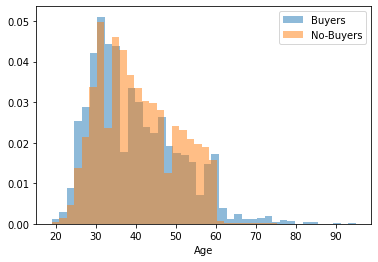

In [382]:
age_data = data[['age','y']]
buyers = age_data[age_data['y']==1]
no_buyers = age_data[age_data['y']==0]
plt.hist(buyers['age'], bins=40, alpha=0.5, density=True, label='Buyers')
plt.hist(no_buyers['age'], bins=40, alpha=0.5, density=True, label = 'No-Buyers')
plt.legend(loc="upper right")
plt.xlabel("Age")
plt.show()

In [385]:
data[(data['age']<=35) & (data['age']>=20)]['y'].mean()

0.0844889399986471

In [386]:
data[(data['age']>=60)]['y'].mean()

0.18019257221458046

## What makes customers buy?

The most significant features that makes customers buy are:


In the exploratory data analysis section, we have observed some features that has higher sale rates than others.

I am now going to combine EDA with feature importance values that is given by the model to answer What makes customer buy?

1. Duration: Longer calls more likely ending up in sales. You can find the visual evidence for this suggestion below.

2. Contact Type: Cellular contacts more likely ending up in sales. Model suggests this feature is important and you can find the analysis for this on EDA section.

3. Month: The contact month also affecting the sales. October and March has higher sale rates than other months followed by april and february. But notice that March has fewer observation than others and October has very few observations. Therefore model thinks month's beign october does not have any significant effect on sales. Need to observe more values to be able to say something about October.



### Duration

In [298]:
duration_data = data[['duration','y']]
buyers = duration_data[duration_data['y']==1]
no_buyers = duration_data[duration_data['y']==0]

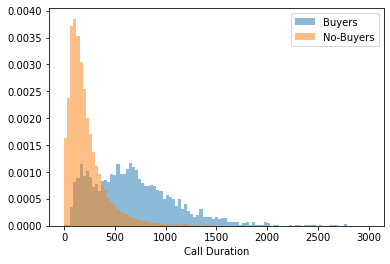

In [301]:
bins = np.linspace(0,3000,100)
plt.hist(buyers['duration'], bins=bins, alpha=0.5, density=True, label='Buyers')
plt.hist(no_buyers['duration'], bins=bins, alpha=0.5, density=True, label = 'No-Buyers')
plt.legend(loc="upper right")
plt.xlabel("Call Duration")
plt.show()

The call durations of No-buyers are left-skewed and most observations are at lower durations.

There are not many observations of long call durations for no-buyers.

On the other hand, the call durations of Buyers are more spread-out to higher calls.

This means that there is a correlation between Call duration and Subscribing.

It can be either longer duration calls more likely to end up with sale or(/and) the if the sale is made on phone and after the sale more talking is required then the calls that ended up in sales might cause the duration to be longer. But this information is not given in the problem.

### Balance

In [354]:
balance_data = data[['balance','y']]
buyers = balance_data[balance_data['y']==1]
no_buyers = balance_data[balance_data['y']==0]

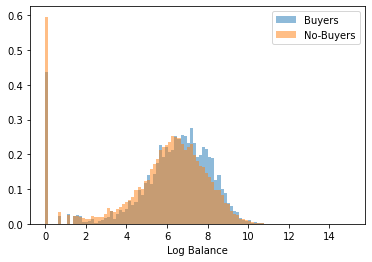

In [360]:
bins = np.linspace(0,15,100)
plt.hist(np.log(buyers['balance']+1), bins=bins, alpha=0.5, density=True, label='Buyers')
plt.hist(np.log(no_buyers['balance']+1), bins=bins, alpha=0.5, density=True, label = 'No-Buyers')
plt.legend(loc="upper right")
plt.xlabel("Log Balance")
plt.show()

The distribution of buyer balances are a shifted to right than the distribution of no-buyer balances

This means the higher balance means higher chances of subscribing but not quite significant.

In [327]:
print("No-Buyers balance mean:", no_buyers.balance.mean())
print("Buyers balance mean:", buyers.balance.mean())

No-Buyers balance mean: 1249.7525334195775
Buyers balance mean: 1588.495856353591


In [362]:
data[data['balance']==0]['y'].mean()

0.05578061701464631